# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 2 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# Check if auto-reload is available
print(f"Auto-reload available: {afml.AUTO_RELOAD_AVAILABLE}")

# Setup with auto-reload enabled
app = afml.setup_jupyter(enable_auto_reload=True)

# # --- Logging (Optional but Recommended) ---
# from loguru import logger
# from pathlib import Path

# # Optional: clear old logs
# log_path = Path("logs") / "afml_session.log"
# log_path.parent.mkdir(exist_ok=True)
# log_path.unlink(missing_ok=True)

# # Configure Loguru
# logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
# logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-09-23 21:00:49.182 | DEBUG    | afml.cache:<module>:349 - Auto-reload functionality available
2025-09-23 21:00:49.183 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-23 21:00:49.187 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-09-23 21:00:49.189 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-09-23 21:00:49.191 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-23 21:00:49.194 | INFO     | afml.cache:initialize_cache_system:318 -   Loaded stats: 4 functions, 41.2% hit rate
2025-09-23 21:00:51.956 | DEBUG    | afml.cache.selective_cleaner:_load_tracking_data:39 - Loaded tracking data for 17 functions
2025-09-23 21:00:57.028 | DEBUG    | afml:<module>:91 - Imported lightweight modules direct

Auto-reload available: True
Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [2]:
import warnings
import winsound
from datetime import datetime as dt
from datetime import timedelta
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import talib
from sklearn.ensemble import RandomForestClassifier

from afml.backtest_statistics import calculate_performance_metrics
from afml.backtester import (
    compare_pr_curves,
    compare_roc_curves,
    compare_roc_pr_curves,
    get_optimal_threshold,
    labeling_reports,
    meta_labeling_classification_report_images,
    meta_labeling_classification_report_tables,
    meta_labeling_reports,
    run_meta_labeling_analysis,
    train_model,
    train_model_with_trend,
)
from afml.bet_sizing.bet_sizing import (
    bet_size_budget,
    bet_size_probability,
    bet_size_reserve,
)
from afml.cache import cache_maintenance, clear_afml_cache, selective_cache_clear
from afml.data_structures.bars import *
from afml.features import get_fractal_features, get_time_features, is_stationary
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    drop_labels,
    get_event_weights,
    get_events,
    # get_trend_scanning_meta_labels,
    trend_scanning_labels,
    triple_barrier_labels,
)
from afml.mt5.load_data import (
    clean_tick_data,
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
)
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
    plot_bbands,
    plot_bbands_dual_bbp_bw,
)
from afml.util import (
    CLEAN_DATA_PATH,
    COMMODITIES,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    GREEKS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    get_period_vol,
    smart_subscript,
    to_subscript,
    value_counts_data,
)

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [3]:
# clear_afml_cache()
pprint(cache_maintenance(), sort_dicts=False)

2025-09-23 21:01:01 | INFO     | No function changes detected
2025-09-23 21:01:01 | INFO     | Cache maintenance completed: 10 functions checked
{'functions_checked': 10,
 'changed_functions': [],
 'cleared_functions': [],
 'size_cleared_mb': 0,
 'old_files_removed': 0}


## 1. Data Preparation

In [4]:
account = "FundedNext_STLR2_6K"
# account = "METAQUOTES_DEMO_25K"
# account = login_mt5(account)
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date

In [5]:
def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict.get(timeframe)
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
            print(f"Loading ticks from {CLEAN_DATA_PATH}...")
        except FileNotFoundError:
            print(f"Downloading ticks to {DATA_PATH}...")
            save_data_to_parquet(DATA_PATH, symbol, start_date, end_date, account)
            tick_df = load_tick_data(DATA_PATH, symbol, start_date, end_date, account, columns)
            tick_df = clean_tick_data(tick_df)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [6]:
bb_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(bb_timeframe)
print(f"{bb_timeframe} = tick-{tick_bar_size}")
bb_time_bars, bb_tick_bars = get_data(symbol, bb_timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"

M5 = tick-200
Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


In [7]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (1, 2, 50)
min_ret = 0.0
bb_vol_multiplier = 1
linear_decay = False

#### Volatility Charts

In [8]:
# start = "2018-01-01 06:00"
# end = "2018-03-01 06:00"
# plot_timeframe = "H1"
# df_time_bars, df_tick_bars = get_data(symbol, plot_timeframe)
# vol_lookback0 = 100

In [9]:
# close_time = df_time_bars.close.loc[start:end]
# target_time = get_daily_vol(close_time, vol_lookback0).reindex(close_time.index)
# side, t_events_time = get_entries(bb_strategy, df_time_bars, filter_threshold=target_time.mean())

# fig, ax = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3,2], sharex=True)

# close_time.plot(ax=ax[0], legend=True, ylabel="Price", linewidth=1, grid=True, alpha=0.7)
# ax[0].scatter(t_events_time, close_time.reindex(t_events_time), marker='x', color='red', s=40)
# (target_time * 100).plot(ax=ax[1], legend=True, ylabel=r"$\sigma$ (%)", label=fr"$\sigma$ Daily EWM({vol_lookback0})", linewidth=1, grid=True)

# fig.suptitle(f"{symbol} ({plot_timeframe})", fontsize=13)
# fig.subplots_adjust(top=0.9)

In [10]:
# close_tick = df_tick_bars.close.loc[start:end]
# target_tick = get_daily_vol(close_tick, vol_lookback0)
# side, t_events_tick = get_entries(bb_strategy, df_tick_bars, filter_threshold=target_tick.mean())

# fig, ax = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3,2], sharex=True)

# close_tick.plot(ax=ax[0], legend=True, ylabel="Price", linewidth=1, grid=True, alpha=0.7)
# ax[0].scatter(t_events_tick, close_tick.reindex(t_events_tick), marker='x', color='red', s=40)
# (target_tick * 100).plot(ax=ax[1], legend=True, ylabel=r"$\sigma$ (%)", label=fr"$\sigma$ Daily EWM({vol_lookback0})", linewidth=1, grid=True)

# fig.suptitle(f"{symbol} ({f'tick-{df_tick_bars.tick_volume.iloc[0]}'})", fontsize=13)
# plt.subplots_adjust(top=0.9)

### Time-Bars

In [46]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 100
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close

thres = vol_target.mean()
_, t_events = get_entries(bb_strategy, bb_df, filter_threshold=thres)

vertical_barriers = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

Bollinger_w20_std1.5 Signals:

        count  proportion
side                     
 0    198,417    0.671105
-1     48,987    0.165689
 1     48,253    0.163206

2025-09-22 19:20:51 | INFO     | 9,708 CUSUM-filtered events
2025-09-22 19:20:52 | INFO     | Bollinger_w20_std1.5 | 7,834 (8.06%) trade events selected by CUSUM filter (threshold = 0.1425%).


#### Feature Engineering

In [47]:
bb_feat = create_bollinger_features(bb_time_bars, bb_period, bb_std)
bb_feat_time = bb_feat.copy()
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

2025-09-22 19:21:01 | INFO     | 
Dropped features with correlation > 0.8: 
	['sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_200']
Kept features: 
	['sma_diff_5_20', 'sma_diff_5_50', 'sma_diff_20_100', 'sma_diff_100_200']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516825 entries, 2018-01-02 23:20:00 to 2024-12-31 00:00:00
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   close                516825 non-null  float32
 1   spread               516825 non-null  float32
 2   vol                  516825 non-null  float32
 3   h1_vol               516825 non-null  float32
 4   h4_vol               516825 non-null  float32
 5   d1_vol               516825 non-null  float32
 6   ret                  516825 non-null  float32
 7   ret_5                516825 non-null  float32
 8   ret_10               516825 non-null  float32
 9   ret_1_lag

#### Fixed-Time Horizon Method

In [13]:
bb_events_fh = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[0,0],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
bb_events_fh_time = bb_events_fh.copy()
print(f"Fixed-Time Horizon (h={bb_time_horizon}):")
value_counts_data(bb_events_fh.bin, verbose=True)

av_uniqueness = bb_events_fh['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Fixed-Time Horizon (h=50):

     count  proportion
bin                   
1    4,046    0.516995
0    3,780    0.483005

Average Uniqueness: 0.5397


#### Triple-Barrier Method

In [14]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tb = get_event_weights(bb_events_tb, close)
bb_events_tb_time = bb_events_tb.copy()

print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

av_uniqueness = bb_events_tb['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h=50):

     count  proportion
bin                   
0    4,952    0.632763
1    2,874    0.367237

Average Uniqueness: 0.7018


#### Trend-Scanning Method

In [ ]:
span = (5, bb_time_horizon)
volatility_threshold = 0.0

In [48]:
span = (5, 20)
vertical_barriers_20 = add_vertical_barrier(t_events, close, num_bars=20)
bb_events_trend_tb = get_trend_scanning_meta_labels(
    close, vol_target, bb_side, t_events, vertical_barriers_20, bb_sl_barrier, 
    min_ret, span, volatility_threshold
    )
bb_events_trend_tb_time_20 = bb_events_trend_tb.copy()
# bb_events_trend_tb_time_20.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold})")
value_counts_data(bb_events_trend_tb_time_20["ts_bin"], verbose=True)

print(f"Triple-Barrier (pt={0}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_trend_tb_time_20["bin"], verbose=True)

av_uniqueness = bb_events_trend_tb_time_20['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

# bb_events_trend_time.info()

2025-09-22 19:21:13 | INFO     | Dropped label: 0 - 2.7050%
2025-09-22 19:21:14 | INFO     | Trend-Scanning (σ = 0.0)

Trend-Scanning Labels (σ = 0.0)

        count  proportion
ts_bin                   
-1      3,824    0.502695
 1      3,783    0.497305

Triple-Barrier (pt=0, sl=2, h=50):

     count  proportion
bin                   
1    4,183    0.549888
0    3,424    0.450112

Average Uniqueness: 0.8229


In [49]:
span = (5, 30)
vertical_barriers_30 = add_vertical_barrier(t_events, close, num_bars=30)
bb_events_trend_tb = get_trend_scanning_meta_labels(
    close, vol_target, bb_side, t_events, vertical_barriers_30, bb_sl_barrier, 
    min_ret, span, volatility_threshold
    )
bb_events_trend_tb_time_30 = bb_events_trend_tb.copy()
# bb_events_trend_tb_time_30.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold})")
value_counts_data(bb_events_trend_tb_time_30["ts_bin"], verbose=True)

print(f"Triple-Barrier (pt={0}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_trend_tb_time_30["bin"], verbose=True)

av_uniqueness = bb_events_trend_tb_time_30['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

# bb_events_trend_time.info()

2025-09-22 19:21:19 | INFO     | Dropped label: 0 - 0.5361%
2025-09-22 19:21:19 | INFO     | Trend-Scanning (σ = 0.0)

Trend-Scanning Labels (σ = 0.0)

        count  proportion
ts_bin                   
 1      3,924    0.504565
-1      3,853    0.495435

Triple-Barrier (pt=0, sl=2, h=50):

     count  proportion
bin                   
1    4,225    0.543269
0    3,552    0.456731

Average Uniqueness: 0.7252


In [50]:
span = (5, 50)
vertical_barriers_50 = add_vertical_barrier(t_events, close, num_bars=50)
bb_events_trend_tb = get_trend_scanning_meta_labels(
    close, vol_target, bb_side, t_events, vertical_barriers_50, bb_sl_barrier, 
    min_ret, span, volatility_threshold
    )
bb_events_trend_tb_time_50 = bb_events_trend_tb.copy()
# bb_events_trend_tb_time_50.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold})")
value_counts_data(bb_events_trend_tb_time_50["ts_bin"], verbose=True)

print(f"Triple-Barrier (pt={0}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_trend_tb_time_50["bin"], verbose=True)

av_uniqueness = bb_events_trend_tb_time_50['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

# bb_events_trend_time.info()

2025-09-22 19:21:21 | INFO     | Dropped label: 0 - 0.0585%
2025-09-22 19:21:21 | INFO     | Trend-Scanning (σ = 0.0)

Trend-Scanning Labels (σ = 0.0)

        count  proportion
ts_bin                   
 1      3,950    0.504921
-1      3,873    0.495079

Triple-Barrier (pt=0, sl=2, h=50):

     count  proportion
bin                   
1    4,183    0.534705
0    3,640    0.465295

Average Uniqueness: 0.5804


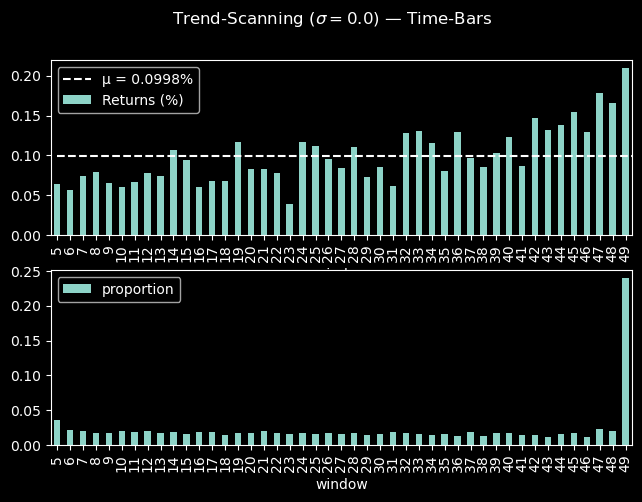

In [33]:
events = bb_events_trend_tb[bb_events_trend_tb["bin"] == 1]
ret_by_window = events.groupby(['window'])["ret"].mean() * 100
ave_ret = ret_by_window.mean()

fig, ax = plt.subplots(2, 1, figsize=(7.5, 5), dpi=100)
ret_by_window.plot(kind="bar", label="Returns (%)", ax=ax[0])
ax[0].hlines(ave_ret, xmin=0, xmax=bb_time_horizon, linestyles="--", label=f"μ = {ave_ret:.4f}%")
ax[0].legend()
events["window"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[1], legend=True)
fig.suptitle(fr"Trend-Scanning ($\sigma={volatility_threshold}$) — Time-Bars")
plt.subplots_adjust(top=0.88);

#### Random Forest

In [18]:
dashes = "-" * 60

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

random_state = 10
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Strategy: Bollinger_w20_std1.5


##### Unweighted

2025-09-22 18:58:37 | INFO     | Samples are equally weighted.
2025-09-22 18:58:37 | INFO     | Training on 5,477 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1113
           1       0.53      1.00      0.69      1234

    accuracy                           0.53      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.28      0.53      0.36      2347


Confusion Matrix:
[[   0 1113]
 [   0 1234]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.46      0.47      1113
           1       0.53      0.56      0.55      1234

    accuracy      

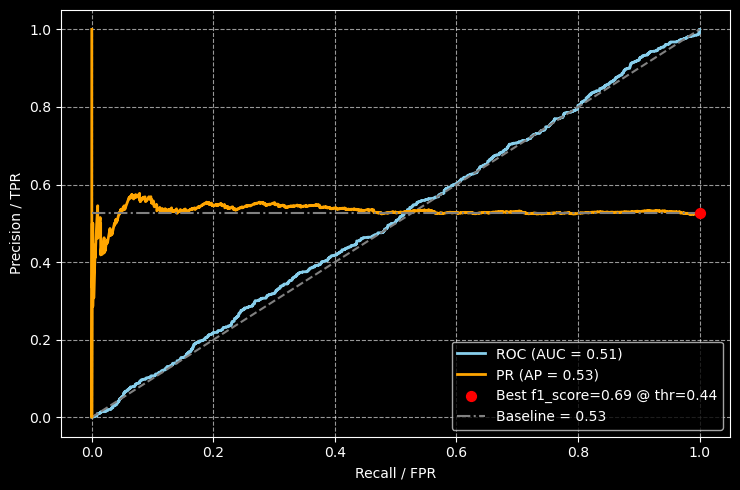

In [ ]:
model_bb_fh_time = train_model(model=rf, X=bb_feat_time, events=bb_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_fh_time, plot=True)

2025-09-22 18:58:57 | INFO     | Samples are equally weighted.
2025-09-22 18:58:58 | INFO     | Training on 5,478 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1453
           1       0.38      1.00      0.55       894

    accuracy                           0.38      2347
   macro avg       0.19      0.50      0.28      2347
weighted avg       0.15      0.38      0.21      2347


Confusion Matrix:
[[   0 1453]
 [   0  894]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.56      0.63      1453
           1       0.47      0.62      0.53       894

    accuracy          

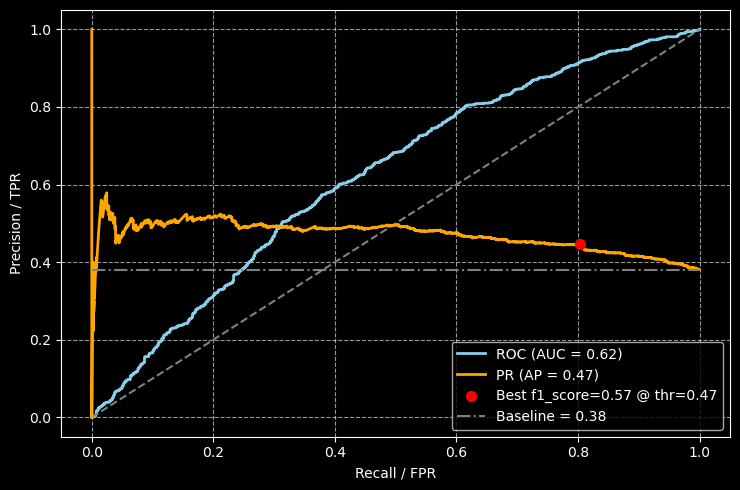

In [ ]:
model_bb_tbl_time = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tbl_time, plot=True)

2025-09-22 19:22:50 | INFO     | Samples are equally weighted.
2025-09-22 19:22:50 | INFO     | Training on 5,324 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.54      0.54      0.54      1134
           1       0.54      0.54      0.54      1148

    accuracy                           0.54      2282
   macro avg       0.54      0.54      0.54      2282
weighted avg       0.54      0.54      0.54      2282


Confusion Matrix:
[[617 517]
 [530 618]]
2025-09-22 19:23:06 | INFO     | Samples are equally weighted.
2025-09-22 19:23:06 | INFO     | Training on 1,544 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) META-LABELING EVALUATION REPORT
------------------------

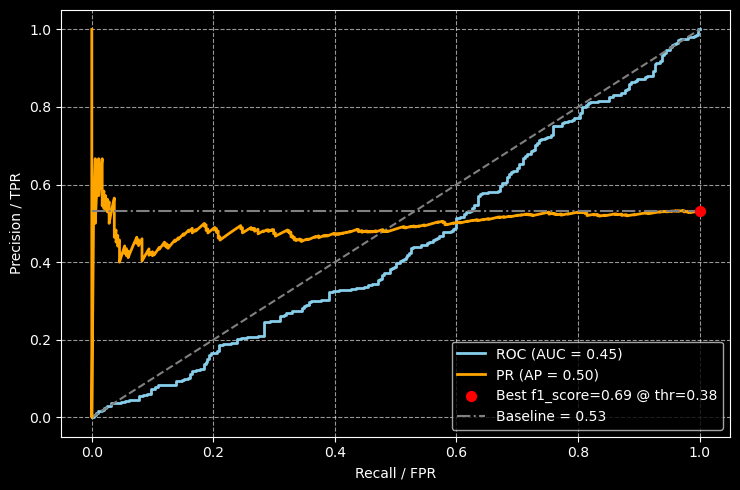

In [ ]:
model_bb_trend_time_20 = train_model(
    model=rf, X=bb_feat_time, y=bb_events_trend_tb_time_20["ts_bin"], events=bb_events_trend_tb_time_20
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_bb_trend_time_20)

model_bb_trend_tbl_time_20 = train_model_with_trend(
    model=rf,
    ts_model_data=model_bb_trend_time_20,
    X=bb_feat_time, 
    events=bb_events_trend_tb_time_20,
    agreement_only=True,
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) META-LABELING EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_trend_tbl_time_20, plot=True)

2025-09-22 19:23:15 | INFO     | Samples are equally weighted.
2025-09-22 19:23:15 | INFO     | Training on 5,440 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.53      0.55      0.54      1144
           1       0.55      0.52      0.53      1189

    accuracy                           0.54      2333
   macro avg       0.54      0.54      0.54      2333
weighted avg       0.54      0.54      0.54      2333


Confusion Matrix:
[[629 515]
 [569 620]]
2025-09-22 19:23:31 | INFO     | Samples are equally weighted.
2025-09-22 19:23:31 | INFO     | Training on 1,565 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) META-LABELING EVALUATION REPORT
------------------------

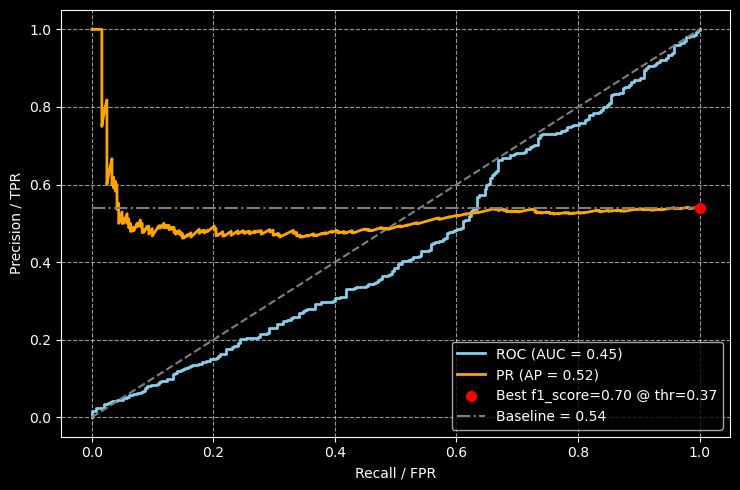

In [ ]:
model_bb_trend_time_30 = train_model(
    model=rf, X=bb_feat_time, y=bb_events_trend_tb_time_30["ts_bin"], events=bb_events_trend_tb_time_30
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_bb_trend_time_30)

model_bb_trend_tbl_time_30 = train_model_with_trend(
    model=rf,
    ts_model_data=model_bb_trend_time_30,
    X=bb_feat_time, 
    events=bb_events_trend_tb_time_30,
    agreement_only=True,
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) META-LABELING EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_trend_tbl_time_30, plot=True)

2025-09-22 19:23:41 | INFO     | Samples are equally weighted.
2025-09-22 19:23:41 | INFO     | Training on 5,475 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.52      0.60      0.55      1142
           1       0.55      0.47      0.51      1204

    accuracy                           0.53      2346
   macro avg       0.53      0.53      0.53      2346
weighted avg       0.53      0.53      0.53      2346


Confusion Matrix:
[[683 459]
 [641 563]]
2025-09-22 19:23:58 | INFO     | Samples are equally weighted.
2025-09-22 19:23:58 | INFO     | Training on 1,464 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) META-LABELING EVALUATION REPORT
------------------------

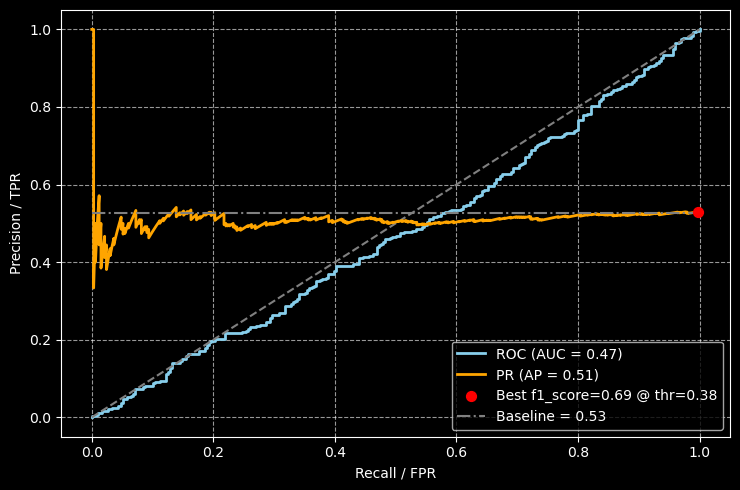

In [ ]:
model_bb_trend_time_50 = train_model(
    model=rf, X=bb_feat_time, y=bb_events_trend_tb_time_50["ts_bin"], events=bb_events_trend_tb_time_50
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_bb_trend_time_50)

model_bb_trend_tbl_time_50 = train_model_with_trend(
    model=rf,
    ts_model_data=model_bb_trend_time_50,
    X=bb_feat_time, 
    events=bb_events_trend_tb_time_50,
    agreement_only=True,
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) META-LABELING EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_trend_tbl_time_50, plot=True)

##### Return-Weighted

2025-09-22 03:08:16 | INFO     | Samples weighted by return attribution.
2025-09-22 03:08:16 | INFO     | Training on 5,477 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1113
           1       0.53      1.00      0.69      1234

    accuracy                           0.53      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.28      0.53      0.36      2347


Confusion Matrix:
[[   0 1113]
 [   0 1234]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      1.00      0.64      1113
           1       0.00      0.00      0.00      1234

    accu

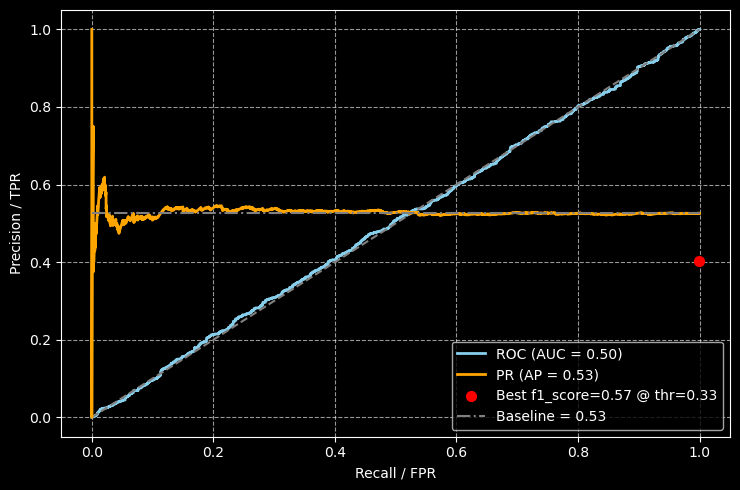

In [ ]:
model_bb_fh_time_w = train_model(model=rf, X=bb_feat_time, events=bb_events_fh_time, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_fh_time_w, plot=True)

2025-09-22 03:08:46 | INFO     | Samples weighted by return attribution.
2025-09-22 03:08:46 | INFO     | Training on 5,478 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1453
           1       0.38      1.00      0.55       894

    accuracy                           0.38      2347
   macro avg       0.19      0.50      0.28      2347
weighted avg       0.15      0.38      0.21      2347


Confusion Matrix:
[[   0 1453]
 [   0  894]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      1.00      0.76      1453
           1       1.00      0.00      0.00       894

    accuracy

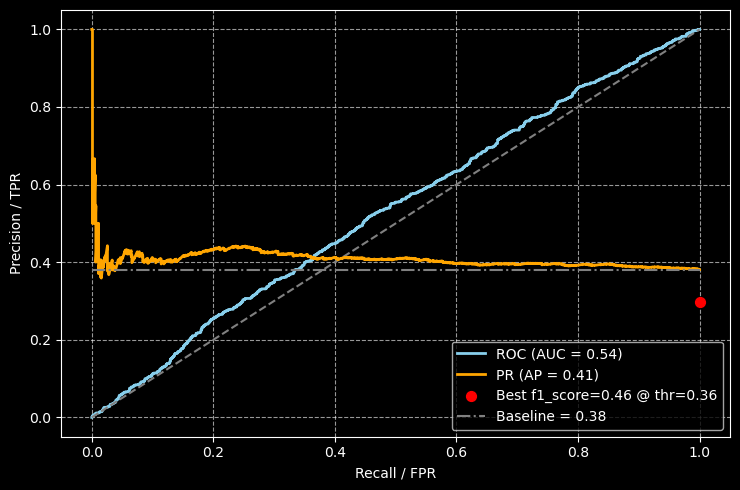

In [ ]:
model_bb_tbl_time_w = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tbl_time_w, plot=True)

2025-09-22 04:05:36 | INFO     | Samples weighted by t_value.
2025-09-22 04:05:36 | INFO     | Training on 5,475 samples...

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.52      0.59      0.55      1142
           1       0.55      0.48      0.51      1204

    accuracy                           0.53      2346
   macro avg       0.53      0.53      0.53      2346
weighted avg       0.53      0.53      0.53      2346


Confusion Matrix:
[[675 467]
 [630 574]]
2025-09-22 04:05:54 | INFO     | Samples weighted by return attribution.
2025-09-22 04:05:54 | INFO     | Training on 1,642 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   suppo

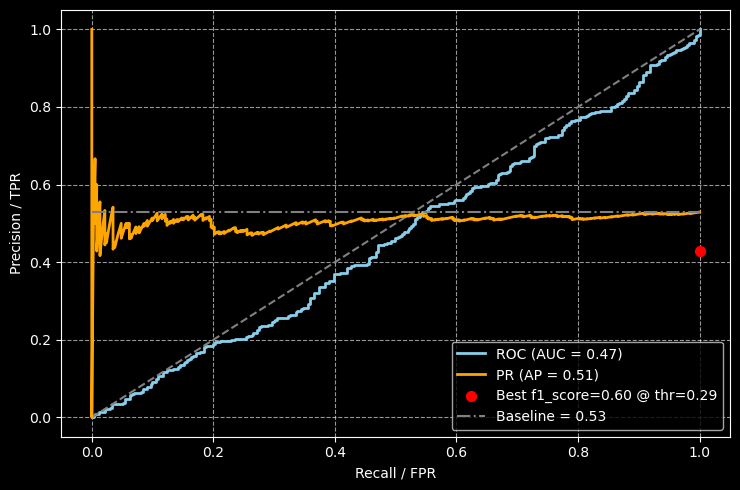

In [ ]:
model_bb_trend_time_w = train_model(
    model=rf, X=bb_feat_time, y=bb_events_trend_tb_time["ts_bin"], events=bb_events_trend_tb_time, weighting="t_value"
    )
labeling_reports(model_bb_trend_time_w)


model_bb_trend_tbl_time_w = train_model_with_trend(
    model=rf,
    ts_model_data=model_bb_trend_time_w,
    X=bb_feat_time, 
    events=bb_events_trend_tb_time,
    agreement_only=False,
    weighting="return",
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_trend_tbl_time_w, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "time_bars", bb_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

# Simulated loop over labeling methods
labeling_methods = [
    "fixed-horizon", 
    "triple-barrier", 
    "trend-scanning", 
    ]
models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_time]

In [ ]:
# fp = Path(dirpath, "unweighted")
# fp_plots = Path(dirpath, "plots", "unweighted")
# fp_plots.mkdir(parents=True, exist_ok=True)
# bb_models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_time]

# bb_roc = compare_roc_curves(
#     bb_models[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc = compare_roc_curves(bb_models[:2], plot_titles[:2], columns=2)
# # bb_roc.savefig(dirpath / "bb_roc_barrier_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc_trend = compare_roc_curves(bb_models[2:], plot_titles[2:], columns=2)
# # bb_roc_trend.savefig(dirpath / "bb_roc_trend_comparison.png", bbox_inches="tight", dpi=100)

# # meta_labelinglassification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
# fp_w = Path(dirpath, "return_weighted") 
# fp_plots = Path(dirpath, "plots", "return_weighted")
# fp_plots.mkdir(parents=True, exist_ok=True)

# bb_models_w = [model_bb_fh_time_w, model_bb_tbl_time_w, model_bb_trend_time_w]
# bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
# filenames_w = [f"{w}_w" for w in filenames]

# bbb_roc = compare_roc_curves(
#     bb_models_w[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# meta_labelinglassification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

In [ ]:
# fp_tw = Path(dirpath, "time_weighted") 
# plot_titles_tw = [fr"$\lambda = {decay}$" for decay in time_decays]
# columns = 2
# height = 7.5
# fig_titles = [f"Time-Decay ($\lambda$): {method} ROC Curves" for method in bb_titles]

# bb_models_tw, bb_titles_tw, filenames_tw = [], [], []
# for time_decay, labels in models_bb_time_tw.items():
#     for i, (label, model) in enumerate(labels.items()):
#         bb_models_tw.append(model)
#         bb_titles_tw.append(f"Time-Weighted (λ = {time_decay}) {bb_titles[i]}")
#         filenames_tw.append(f"{filenames[i]}_tw_{time_decay}")

# meta_labelinglassification_reports(model_data=bb_models_tw, titles=bb_titles_tw, output_filenames=filenames_tw, path=fp_tw)

# fig_title = fig_titles[0]
# bb_roc_fh_tw = compare_roc_curves(bb_models_tw[::4], plot_titles_tw, fig_title, columns, height)
# bb_roc_fh_tw.savefig(dirpath / "bb_roc_fixed_horizon_comparison_time_weighted.png", bbox_inches="tight", dpi=100)

##### Out-of-Sample

In [54]:


# Create events set for model
df = bb_time_bars[sample_end:]
close = df.close.copy()
target = get_daily_vol(bb_time_bars.close, vol_lookback).reindex(df.index) * bb_vol_multiplier

side, t_events = get_entries(bb_strategy, df, on_crossover=False)
vertical_barrier_times = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

# Create feature set for model
X_test = bb_feat_time.reindex(t_events).dropna().copy()
value_counts_data(X_test.side, verbose=True)
X_test.info()

bb_events_fh_time_oos = get_events(
    close, t_events, 
    pt_sl=[0, 0],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )

bb_events_tb_time_oos = get_events(
    close, t_events, 
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )

bb_events_trend_time_oos_20 = get_events(
    close, t_events, 
    pt_sl=[0, bb_sl_barrier],
    target=target, 
    vertical_barrier_times=add_vertical_barrier(t_events, close, num_bars=20),
    side_prediction=bb_side,
    )

bb_events_trend_time_oos_30 = get_events(
    close, t_events, 
    pt_sl=[0, bb_sl_barrier],
    target=target, 
    vertical_barrier_times=add_vertical_barrier(t_events, close, num_bars=30),
    side_prediction=bb_side,
    )

bb_events_trend_time_oos_50 = get_events(
    close, t_events, 
    pt_sl=[0, bb_sl_barrier],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )

labeling_methods = [
    "fixed_horizon", 
    "triple_barrier", 
    "trend_scanning", 
    ]
models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_tbl_time_20, model_bb_trend_tbl_time_30, model_bb_trend_tbl_time_50]
events_oos = {"fixed_horizon": bb_events_fh_time_oos, 
              "triple_barrier": bb_events_tb_time_oos,
              "trend_scanning (5, 20)": bb_events_trend_time_oos_20,
              "trend_scanning (5, 30)": bb_events_trend_time_oos_30,
              "trend_scanning (5, 50)": bb_events_trend_time_oos_50,
              }

2025-09-22 19:27:12 | INFO     | Bollinger_w20_std1.5 | 71,159 (100.00%) trade events.

       count  proportion
side                    
-1    35,933    0.504968
 1    35,226    0.495032

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71159 entries, 2021-12-31 02:40:00 to 2024-12-31 00:00:00
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   close                71159 non-null  float32
 1   spread               71159 non-null  float32
 2   vol                  71159 non-null  float32
 3   h1_vol               71159 non-null  float32
 4   h4_vol               71159 non-null  float32
 5   d1_vol               71159 non-null  float32
 6   ret                  71159 non-null  float32
 7   ret_5                71159 non-null  float32
 8   ret_10               71159 non-null  float32
 9   ret_1_lag_1          71159 non-null  float32
 10  ret_5_lag_1          71159 non-null  float32
 11  ret_10_lag_1

In [55]:
bet_sizing_methods = [None, 'probability', 'budget', 'reserve', 'dynamic']
bet_sizing = bet_sizing_methods[0]

if bet_sizing == "probability":
    bet_sizing_args = dict(step_size=0.0, average_active=False)
else:
    bet_sizing_args = dict()

bb_model_results_time = {}
time_metrics_oos = {"primary_model": {}, "meta_model": {}}
bb_metrics_time = pd.DataFrame()

In [56]:
i, j = 2, 6
for model_name, model in zip(labeling_methods[i : j], models[i : j]):
    prob = model.fit.predict_proba(X_test)[:, 1]
    prob = pd.Series(prob, index=X_test.index)
    name = f"{bb_strategy.get_strategy_name()} ({model_name.replace('_', ' ').title()})"
    results = run_meta_labeling_analysis(
        events=events_oos[model_name],
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=name,
        bet_sizing=bet_sizing,
        **bet_sizing_args
        )
    bb_model_results_time[model_name] = results
    bb_metrics_time[model_name] = results["meta_metrics"]

bb_metrics_time

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ts_bin
- ts_prob


In [ ]:
for model_name, model in zip(
    ["unweighted", "return_weighted"], 
    [model_bb_tbl_time, model_bb_tbl_time_w]
    ):
    prob = model.fit.predict_proba(X_test)[:, 1]
    prob = pd.Series(prob, index=X_test.index)

    results = run_meta_labeling_analysis(
        events=bb_events_tb_time_oos,
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=bb_strategy.get_strategy_name(),
        bet_sizing=bet_sizing,
        **bet_sizing_args
        )
    bb_model_results_time[f"triple_barrier_{model_name}"] = results
    bb_metrics_time[f"triple_barrier_{model_name}"] = results["meta_metrics"]

bb_metrics_time


Meta-Labeling Performance Analysis: Bollinger_w20_std1.5

Signal Filtering Summary:
  Total Primary Signals: 71,147
  Filtered Signals: 53,966
  Filter Rate: 24.15%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   1,731.29%       1,444.67%       -16.6%         
Annualized Return              163.53%         148.99%         -8.9%          
Sharpe Ratio                   6.8280          8.5534          +25.3%         
Sortino Ratio                  8.9424          11.1258         +24.4%         
Calmar Ratio                   3.4373          3.8842          +13.0%         

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   47.57%          38.36%          +19.4%         
Avg Drawdown                   2.75%           2.17%           +21.0%         
Volatility (Ann.)              0.4576          0.4501          +1.7%          
Downside Volat

,fixed_horizon_unweighted,fixed_horizon_return_weighted,triple_barrier_unweighted,triple_barrier_return_weighted
total_return,4.822452,4.822452,14.44669,14.44669
annualized_return,0.798776,0.798776,1.489935,1.489935
volatility,0.559781,0.559781,0.450077,0.450077
downside_volatility,0.423702,0.423702,0.346015,0.346015
sharpe_ratio,4.589304,4.589304,8.553424,8.553424
sortino_ratio,6.063234,6.063234,11.125808,11.125808
var_95,-0.003023,-0.003023,-0.002772,-0.002772
cvar_95,-0.004956,-0.004956,-0.004075,-0.004075
skewness,0.0221,0.0221,-0.458396,-0.458396
kurtosis,7.986032,7.986032,4.150295,4.150295


In [ ]:
model = model_bb_trend_time
# opt_threshold = get_optimal_threshold(model)

events = get_events(
    close, t_events, 
    pt_sl=[0, bb_sl_barrier], 
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )

prob = model.fit.predict_proba(X_test)[:, 1]
prob = pd.Series(prob, index=X_test.index)

results = run_meta_labeling_analysis(
    events=events,
    meta_probabilities=prob,
    close=close,
    # confidence_threshold=opt_threshold["threshold"],
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name(),
    bet_sizing=bet_sizing,
    **bet_sizing_args
    )
bb_model_results_time["trend_scanning"] = results


Meta-Labeling Performance Analysis: Bollinger_w20_std1.5

Signal Filtering Summary:
  Total Primary Signals: 71,147
  Filtered Signals: 31,030
  Filter Rate: 56.39%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   1,272.20%       476.33%         -62.6%         
Annualized Return              139.36%         79.27%          -43.1%         
Sharpe Ratio                   5.3004          6.4379          +21.5%         
Sortino Ratio                  8.3059          10.6801         +28.6%         
Calmar Ratio                   3.5156          2.3522          -33.1%         

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   39.64%          33.70%          +15.0%         
Avg Drawdown                   3.52%           3.49%           +0.8%          
Volatility (Ann.)              0.5408          0.6842          -26.5%         
Downside Volat

In [ ]:
from afml.bet_sizing.bet_sizing import bet_size_budget

bet_size_budget(events.t1, events.side)

,t1,side,active_long,active_short,bet_size
time,,,,,
2021-12-31 02:40:00,2021-12-31 06:50:00,1,1,0,0.026316
2021-12-31 02:50:00,2021-12-31 07:00:00,1,2,0,0.052632
2021-12-31 02:55:00,2021-12-31 07:05:00,1,3,0,0.078947
2021-12-31 03:00:00,2021-12-31 07:10:00,1,4,0,0.105263
2021-12-31 03:05:00,2021-12-31 07:15:00,1,5,0,0.131579
...,...,...,...,...,...
2024-12-30 21:00:00,NaT,-1,1,1,0.004577
2024-12-30 22:00:00,NaT,1,0,1,-0.021739
2024-12-30 23:45:00,NaT,-1,0,0,0.000000


In [ ]:
time_metrics_oos = {}
for col, res in bb_model_results_time.items():
    time_metrics_oos.setdefault("primary_model", []).append(pd.Series(res["primary_metrics"], name=col))
    time_metrics_oos.setdefault("meta_model", []).append(pd.Series(res["meta_metrics"], name=col))

primary_metrics_df = pd.concat(time_metrics_oos["primary_model"], axis=1)
meta_metrics_df = pd.concat(time_metrics_oos["meta_model"], axis=1)
# pprint(time_metrics_oos)
primary_metrics_df

,fixed_horizon,triple_barrier
total_return,-1.0,17.31286
annualized_return,-1.0,1.637588
volatility,7.366913,0.457624
downside_volatility,4.559798,0.349421
sharpe_ratio,-24.175337,6.827811
sortino_ratio,-39.05822,8.94214
var_95,-0.084407,-0.002857
cvar_95,-0.104764,-0.004129
skewness,0.102362,-0.49109
kurtosis,0.172942,3.462621


In [ ]:
meta_metrics_df

,fixed_horizon,triple_barrier
total_return,-1.0,6.835008
annualized_return,-1.0,0.987089
volatility,7.366913,0.444707
downside_volatility,4.559798,0.339417
sharpe_ratio,-24.175337,8.599693
sortino_ratio,-39.05822,11.267396
var_95,-0.084407,-0.002678
cvar_95,-0.104764,-0.003993
skewness,0.102362,-0.442031
kurtosis,0.172942,4.331774


In [ ]:
bet_sizes_raw = bet_size_probability(
            events,
            prob.reindex(events.index),
            num_classes=2,
            pred=events.side,
            # **kwargs,
        )
# bet_sizes_raw.describe()
pd.concat([bet_sizes_raw, prob], axis=1).dropna()[bet_sizes_raw < 0]

,bet_size,0
time,,
2021-12-31 02:40:00,-0.041191,0.474210
2021-12-31 02:50:00,-0.044235,0.472308
2021-12-31 04:35:00,-0.014694,0.490793
2021-12-31 07:00:00,-0.037061,0.476792
2021-12-31 08:35:00,-0.002270,0.498578
...,...,...
2024-12-30 11:50:00,-0.093214,0.558149
2024-12-30 13:25:00,-0.050949,0.531885
2024-12-30 13:55:00,-0.032719,0.520492


In [ ]:
pd.concat([results["primary_returns"], results["meta_returns"]], axis=1)

,0,1
time,,
2021-12-31 02:40:00,0.000093,0.000000
2021-12-31 02:50:00,-0.001051,-0.000000
2021-12-31 03:35:00,-0.000429,-0.000429
2021-12-31 04:35:00,-0.000919,-0.000000
2021-12-31 06:05:00,0.000932,-0.000000
...,...,...
2024-12-30 14:10:00,0.001043,-0.001043
2024-12-30 15:15:00,-0.002965,-0.002965
2024-12-30 15:30:00,-0.002764,-0.002764


In [ ]:
model = model_bb_trend_time
# opt_threshold = get_optimal_threshold(model)

events = get_events(
    close, t_events, 
    pt_sl=[0, 0],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=primary_signals,
    ).dropna(subset=["t1"])

prob = model.fit.predict_proba(X_test)[:, 1]
prob = pd.Series(prob, index=X_test.index)

results = run_meta_labeling_analysis(
    close,
    events,
    prob,
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name()
    )
bb_model_results_time[f"trend_scanning_{volatility_threshold}"] = results

NameError: name 'model_bb_trend_time' is not defined

In [ ]:
# # meta_positions = (prob > 0.44).astype("int8")
# # value_counts_data(meta_positions)
# fit = model_bb_fh_time.fit
# prob = pd.Series(fit.predict_proba(X_test)[:, 1], index=X_test.index)

# bet_sizes_raw = bet_size_probability(
#         events,
#         prob,
#         num_classes=2,
#         pred=events['side'],
#         step_size=0,
#         average_active=0,
#     )
# bet_sizes_raw.describe()

### Tick-Bars

In [ ]:
bb_side = bb_strategy.generate_signals(bb_tick_bars)
bb_df = bb_tick_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 100
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close

thres = vol_target.mean()
side, t_events = get_entries(bb_strategy, bb_df, filter_threshold=thres)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(bb_timeframe) if x.isnumeric()))
bb_tick_horizon = bb_time_horizon * tm
if bb_timeframe.startswith("H"):
    bb_tick_horizon *= 60
elif bb_timeframe.startswith("D"):
    bb_tick_horizon *= 60 * 24

h = timedelta(minutes=bb_tick_horizon)
print(f"Time Horizon: {h}")
vertical_barriers_by_time = add_vertical_barrier(t_events, close, minutes=bb_tick_horizon)
# vertical_barriers_by_num_bars = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

Bollinger_w20_std1.5 Signals:

        count  proportion
side                     
 0    297,722    0.696537
 1     65,015    0.152106
-1     64,695    0.151357

2025-09-15 21:58:50 | INFO     | 14,777 CUSUM-filtered events
2025-09-15 21:58:50 | INFO     | Bollinger_w20_std1.5 | 12,921 (9.96%) trade events selected by CUSUM filter (threshold = 0.1263%).
Time Horizon: 4:10:00


#### Feature Engineering

In [ ]:
# No shifting b/c mean-reversion seems to benefit from contemporaneous information
bb_feat = create_bollinger_features(bb_tick_bars, bb_period, bb_std)
bb_feat.info()

bb_feat_tick = bb_feat.copy()
# not_stationary = is_stationary(bb_feat_tick.dropna())

#### Fixed-Time Horizon Method

In [ ]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_by_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
print(f"Fixed-Time Horizon (h={bb_time_horizon}):")
value_counts_data(bb_events_fh.bin, verbose=True)

bb_events_fh_tick = bb_events_fh.copy()

ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()
av_uniqueness = bb_events_fh['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

#### Triple-Barrier Method

In [ ]:
bb_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_by_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tb = get_event_weights(bb_events_tb, close)
bb_events_tb_tick1 = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={h}):")
value_counts_data(bb_events_tb.bin, verbose=True)


ret = bb_events_tb.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tb['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

#### Trend-Scanning Method

In [ ]:
span = (5, bb_time_horizon + 1)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85
side = bb_side.reindex(close.index)

In [ ]:
bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_tick = bb_events_trend.copy()
ret = bb_events_trend.ret
sr_bb_trend = ret.mean() / ret.std()


print(f"Bollinger_w{bb_period}_std{bb_std}:")
print(f"bb_events_trend.shape: {bb_events_trend.shape}\n")

print(f"trend_scanning_meta_labels {volatility_threshold}: \n{value_counts_data(bb_events_trend.bin)}\n")

events = bb_events_trend[bb_events_trend.bin == 1]
ret_by_window = events.groupby(['window'])["ret"].mean() * 100
ave_ret = events["ret"].mean() * 100
fig, ax = plt.subplots(2, 1, figsize=(7.5, 5), dpi=100)
ret_by_window.plot(kind="bar", label="returns (%)", ax=ax[0])
ax[0].hlines(ave_ret, xmin=0, xmax=bb_time_horizon, linestyles="--", label=f"μ = {ave_ret:.4f}%")
ax[0].legend()
events["window"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[1], legend=True)
fig.suptitle(fr"Trend-Scanning ($\sigma={volatility_threshold}$) — Tick-Bars")
plt.subplots_adjust(top=0.88);

#### Random Forest

In [ ]:
dashes = "-" * 60
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

random_state = 52
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Strategy: Bollinger_w20_std1.5


##### Unweighted

In [ ]:
model_bb_fh_tick = train_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_fh_tick, plot=True)

NameError: name 'bb_feat_tick' is not defined

In [ ]:
model_bb_tbl_tick = train_model(model=rf, features=bb_feat_tick, labels=bb_events_tb_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_tbl_tick, plot=True)

In [ ]:
model_bb_trend_tick = train_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = labeling_reports(model_bb_trend_tick, plot=True)

In [ ]:
model_bb_trend_mr_tick = train_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_trend_mr_tick, plot=True)

##### Return-Weighted

In [ ]:
model_bb_fh_tick_w = train_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_fh_tick_w, plot=True)

In [ ]:
model_bb_tbl_tick_w = train_model(model=rf, features=bb_feat_tick, labels=bb_events_tb_tick, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_tbl_tick_w, plot=True)

In [ ]:
model_bb_trend_tick_w = train_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_trend_tick_w, plot=True)

In [ ]:
model_bb_trend_mr_tick_w = train_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick, weighting="return")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_trend_mr_tick_w, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "tick_bars", f"tick-{bb_tick_bars.tick_volume.iloc[0]}")
dirpath.mkdir(parents=True, exist_ok=True)

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

In [ ]:
bb_models = [model_bb_fh_tick, model_bb_tbl_tick, model_bb_trend_tick, model_bb_trend_mr_tick]
fp = Path(dirpath, "unweighted") 
fp.mkdir(parents=True, exist_ok=True)

fp_plots = Path(dirpath, "plots", "unweighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc = compare_roc_curves(
    bb_models[:], plot_titles[:], columns=2, height=7.5, 
    fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
    )
bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)


meta_labeling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
fp_w = Path(dirpath, "return_weighted") 
bb_models_w = [model_bb_fh_tick_w, model_bb_tbl_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
filenames_w = [f"{w}_w" for w in filenames]

fp_plots = Path(dirpath, "plots", "return_weighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc_w = compare_roc_curves(bb_models_w[:], plot_titles[:], columns=2, height=7.5, fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)")
bb_roc_w.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

##### Out-of-Sample

In [ ]:
bb_models_w = [model_bb_fh_tick_w, model_bb_tbl_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
model_preds_tick_w = {}
tick_metrics_oos_w = {}
X = bb_feat_tick.loc[sample_end:]
df_oos = bb_tick_bars.loc[sample_end:]

for i, model in enumerate(bb_models_w):
    df, metrics = backtest_model(model.fit, X, df_oos.close)
    model_preds_tick_w[bb_titles[i]] = df
    tick_metrics_oos_w[filenames[i]] = metrics
    print(f"{bb_titles[i]} done.")

tick_metrics_oos_df_w = pd.DataFrame(tick_metrics_oos_w)
tick_metrics_oos_df_w

#### Time- vs. Tick-Bars

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
pr = compare_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Time-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_time, model_bb_tbl_time] #, model_bb_tbl_tick, model_bb_tbl_tick_w]
metric = "f1"
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Tick-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_tick, model_bb_tbl_tick] #, model_bb_tbl_tick, model_bb_tbl_tick_w]
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df.round(2)
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

## 3. Moving Average Crossover Strategy

In [6]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M30"
tick_bar_size = tick_bar_dict.get(ma_timeframe)
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
ma_bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"

fast_window, slow_window = 50, 100
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (3, 1, 100)
ma_vol_multiplier = 0.5
time_decay = 0.3
linear_decay = False

Loaded EURUSD_M30_tick-1000_2018-01-01-2024-12-31.parq
Loaded EURUSD_M30_time_2018-01-01-2024-12-31.parq


### Time-Bars

In [7]:
ma_side = ma_strategy.generate_signals(ma_time_bars)
ma_df = ma_time_bars.loc[sample_start : sample_end]

print(f"{ma_strategy.get_strategy_name()} Signals:")
value_counts_data(ma_side.reindex(ma_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = fast_window
vol_target = get_daily_vol(ma_df.close, vol_lookback) * ma_vol_multiplier
close = ma_df.close

thres = vol_target.mean()
_, t_events = get_entries(ma_strategy, ma_df, filter_threshold=thres)

vertical_barriers = add_vertical_barrier(t_events, close, num_bars=ma_time_horizon)
linear_decay = False

MACrossover_50_100 Signals:

       count  proportion
side                    
-1    25,240    0.512175
 1    23,941    0.485816
 0        99    0.002009

2025-09-23 21:01:32 | INFO     | 7,656 CUSUM-filtered events
2025-09-23 21:01:32 | INFO     | MACrossover_50_100 | 7,640 (15.53%) trade events selected by CUSUM filter (threshold = 0.1154%).


#### Feature Engineering

In [10]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_time_bars, lr_period=(5, 30))
ma_feat = ma_feat.join(ma_side, how="inner")
ma_feat_time = ma_feat.copy()
ma_feat_time.info()

Memory usage reduced from 49.04 MB to 24.95 MB (49.1% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86195 entries, 2018-01-01 23:30:00 to 2024-12-31 00:00:00
Data columns (total 88 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           86195 non-null  float32
 1   ma_20                           86195 non-null  float32
 2   ma_50                           86195 non-null  float32
 3   ma_100                          86195 non-null  float32
 4   ma_200                          86195 non-null  float32
 5   ma_10_20_cross                  86195 non-null  float64
 6   ma_20_50_cross                  86195 non-null  float64
 7   ma_50_200_cross                 86195 non-null  float64
 8   ma_spread_10_20                 86195 non-null  float32
 9   ma_spread_20_50                 86195 non-null  float32
 10  ma_spread_50_200                86195 non-null  float3

#### Fixed-Time Horizon Method

In [12]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=False,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_time = ma_events_fh.copy()
ma_events_fh.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7622 entries, 2018-01-04 01:30:00 to 2021-12-29 18:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      7622 non-null   datetime64[ns]
 1   trgt    7622 non-null   float64       
 2   ret     7622 non-null   float32       
 3   bin     7622 non-null   int8          
 4   side    7622 non-null   int8          
 5   tW      7622 non-null   float64       
 6   w       7622 non-null   float64       
dtypes: datetime64[ns](1), float32(1), float64(3), int8(2)
memory usage: 600.4 KB


#### Triple-Barrier Method

In [13]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=False,
    verbose=False,
)
ma_events_tb = get_event_weights(ma_events_tb, close)
ma_events_tb_time = ma_events_tb.copy()
ma_events_tb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7639 entries, 2018-01-04 01:30:00 to 2021-12-31 16:30:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      7639 non-null   datetime64[ns]
 1   trgt    7639 non-null   float64       
 2   ret     7639 non-null   float32       
 3   bin     7639 non-null   int8          
 4   side    7639 non-null   int8          
 5   tW      7639 non-null   float64       
 6   w       7639 non-null   float64       
dtypes: datetime64[ns](1), float32(1), float64(3), int8(2)
memory usage: 601.2 KB


#### Trend-Scanning Method

In [103]:
span = (5, ma_time_horizon)
volatility_threshold = 0.0

trend_events = trend_scanning_labels(close, span, volatility_threshold)
trend_events = drop_labels(trend_events)
ma_events_trend_time = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold})")
value_counts_data(ma_events_trend_time["bin"], verbose=False)



Reloading 'afml.labeling.trend_scanning'.
2025-09-24 02:07:29 | INFO     | Auto-cleared changed function cache: afml.labeling.trend_scanning.trend_scanning_labels
2025-09-24 02:07:47 | INFO     | Dropped label: 0 - 0.0102%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7622 entries, 2018-01-04 01:30:00 to 2021-12-29 18:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        7622 non-null   datetime64[ns]
 1   window    7622 non-null   int32         
 2   slope     7622 non-null   float64       
 3   t_value   7622 non-null   float64       
 4   rsquared  7622 non-null   float64       
 5   ret       7622 non-null   float32       
 6   bin       7622 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 364.7 KB

Trend-Scanning Labels (σ = 0.0)


,count,proportion
bin,,
1,"3,844",0.50433
-1,"3,778",0.49567


In [104]:
volatility_threshold1 = 0.05

trend_events = trend_scanning_labels(close, span, volatility_threshold1)
trend_events = drop_labels(trend_events)
ma_events_trend_time1 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time1.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold1})")
value_counts_data(ma_events_trend_time1["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7622 entries, 2018-01-04 01:30:00 to 2021-12-29 18:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        7622 non-null   datetime64[ns]
 1   window    7622 non-null   int32         
 2   slope     7622 non-null   float64       
 3   t_value   7622 non-null   float64       
 4   rsquared  7622 non-null   float64       
 5   ret       7622 non-null   float32       
 6   bin       7622 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 364.7 KB

Trend-Scanning Labels (σ = 0.05)


,count,proportion
bin,,
1,"3,643",0.477959
-1,"3,538",0.464183
0,441,0.057859


In [105]:
volatility_threshold2 = 0.1

trend_events = trend_scanning_labels(close, span, volatility_threshold2)
trend_events = drop_labels(trend_events)
ma_events_trend_time2 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time2.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold2})")
value_counts_data(ma_events_trend_time2["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7622 entries, 2018-01-04 01:30:00 to 2021-12-29 18:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        7622 non-null   datetime64[ns]
 1   window    7622 non-null   int32         
 2   slope     7622 non-null   float64       
 3   t_value   7622 non-null   float64       
 4   rsquared  7622 non-null   float64       
 5   ret       7622 non-null   float32       
 6   bin       7622 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 364.7 KB

Trend-Scanning Labels (σ = 0.1)


,count,proportion
bin,,
1,"3,460",0.453949
-1,"3,330",0.436893
0,832,0.109158


In [106]:
volatility_threshold3 = 0.2

trend_events = trend_scanning_labels(close, span, volatility_threshold3)
trend_events = drop_labels(trend_events)
ma_events_trend_time3 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time3.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold3})")
value_counts_data(ma_events_trend_time3["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7622 entries, 2018-01-04 01:30:00 to 2021-12-29 18:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        7622 non-null   datetime64[ns]
 1   window    7622 non-null   int32         
 2   slope     7622 non-null   float64       
 3   t_value   7622 non-null   float64       
 4   rsquared  7622 non-null   float64       
 5   ret       7622 non-null   float32       
 6   bin       7622 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 364.7 KB

Trend-Scanning Labels (σ = 0.2)


,count,proportion
bin,,
1,"3,072",0.403044
-1,"2,946",0.386513
0,"1,604",0.210443


In [107]:
volatility_threshold4 = 0.3

trend_events = trend_scanning_labels(close, span, volatility_threshold4)
trend_events = drop_labels(trend_events)
ma_events_trend_time4 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time4.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold4})")
value_counts_data(ma_events_trend_time4["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7622 entries, 2018-01-04 01:30:00 to 2021-12-29 18:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        7622 non-null   datetime64[ns]
 1   window    7622 non-null   int32         
 2   slope     7622 non-null   float64       
 3   t_value   7622 non-null   float64       
 4   rsquared  7622 non-null   float64       
 5   ret       7622 non-null   float32       
 6   bin       7622 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 364.7 KB

Trend-Scanning Labels (σ = 0.3)


,count,proportion
bin,,
1,"2,674",0.350827
-1,"2,572",0.337444
0,"2,376",0.311729


In [ ]:
# # Test on distinct market regimes
# regimes = {
#     "high_volatility": "2020-03-01:2020-04-30",  # COVID crash
#     "consolidation": "2021-01-01:2021-03-31",         # Consolidation
#     "downtrend": "2022-05-01:2022-07-31"           # Steady trend
# }

# for regime_name, period in regimes.items():
#     start, end = period.split(":")
#     regime_data = ma_time_bars.loc[start : end, "close"]
#     plt.figure(figsize=(7.5, 4), dpi=100)
#     regime_data.plot(title=f"Market Regime: {regime_name}", figsize=(10, 4))
#     labels = trend_scanning_labels(regime_data, span=(5, 60), volatility_threshold=0.0)
    
#     # Plot: distribution of optimal windows per regime
#     plt.figure(figsize=(7.5, 4), dpi=100)
#     labels['window'].hist(bins=20)
#     plt.title(f"Optimal Horizon Distribution - {regime_name}")
#     plt.xlabel("Window Length")
    
#     # Show average window size and t-stat strength per regime
#     print(f"{regime_name}: Avg Window = {labels['window'].mean():.1f}, "
#           f"Avg |t-value| = {labels['t_value'].abs().mean():.2f}")

### Tick-Bars

In [ ]:
ma_df = ma_tick_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=100) # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")
ma_side = ma_strategy.generate_signals(ma_df)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(ma_timeframe) if x.isnumeric()))
ma_tick_horizon = ma_time_horizon * tm
if ma_timeframe.startswith("H"):
    ma_tick_horizon *= 60
elif ma_timeframe.startswith("D"):
    ma_tick_horizon *= 60 * 24

print(f"Time Horizon: {pd.Timedelta(minutes=tm)}")
vertical_barriers = add_vertical_barrier(t_events, close, minutes=ma_tick_horizon)

#### Feature Engineering

In [108]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df)
ma_feat_tick = ma_feat.copy()
ma_feat.info()

Memory usage reduced from 27.89 MB to 14.12 MB (49.4% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 87 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           49280 non-null  float32
 1   ma_20                           49280 non-null  float32
 2   ma_50                           49280 non-null  float32
 3   ma_100                          49280 non-null  float32
 4   ma_200                          49280 non-null  float32
 5   ma_10_20_cross                  49280 non-null  float64
 6   ma_20_50_cross                  49280 non-null  float64
 7   ma_50_200_cross                 49280 non-null  float64
 8   ma_spread_10_20                 49280 non-null  float32
 9   ma_spread_20_50                 49280 non-null  float32
 10  ma_spread_50_200                49280 non-null  float3

#### Fixed-Time Horizon Method

In [ ]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_tick = ma_events_fh.copy()
ma_events_fh.info()
ret = ma_events_fh.ret
sr_ma_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_fh:.4f}")

#### Triple-Barrier Method

In [ ]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tb = get_event_weights(ma_events_tb, close)
ma_events_tb_tick = ma_events_tb.copy()
ma_events_tb.info()
ret = ma_events_tb.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

In [ ]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    })
ma_metrics_df

#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

vol_target = get_daily_vol(close, lookback=100).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

side = ma_strategy.generate_signals(ma_df)

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_tick = ma_events_trend.copy()
ret = ma_events_trend.ret
sr_ma_trend = ret.mean() / ret.std()

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_mr_tick = ma_events_trend_mr.copy()
ret = ma_events_trend.ret_mr
sr_ma_trend_mr = ret.mean() / ret.std()

# ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    "trend_scanning": sr_ma_trend,
    "trend_scanning_mr": sr_ma_trend_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

### Random Forest

In [21]:
dashes = "-" * 60

plot_titles = [
    f"Fixed-Time Horizon (h = {ma_time_horizon})", 
    f"Triple-Barrier (pt = {ma_pt_barrier}, sl = {ma_sl_barrier}, h = {ma_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    ]
ma_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    ]

name = ma_strategy.get_strategy_name()
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    ]
print(f"Strategy: {ma_strategy.get_strategy_name()}")

random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Strategy: MACrossover_50_100


##### Time-Bars

2025-09-23 21:13:03 | INFO     | Samples are equally weighted.
2025-09-23 21:13:03 | INFO     | Training on 5,308 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1167
           1       0.49      1.00      0.66      1119

    accuracy                           0.49      2286
   macro avg       0.24      0.50      0.33      2286
weighted avg       0.24      0.49      0.32      2286


Confusion Matrix:
[[   0 1167]
 [   0 1119]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.60      0.56      1167
           1       0.51      0.44      0.47      1119

    accuracy      

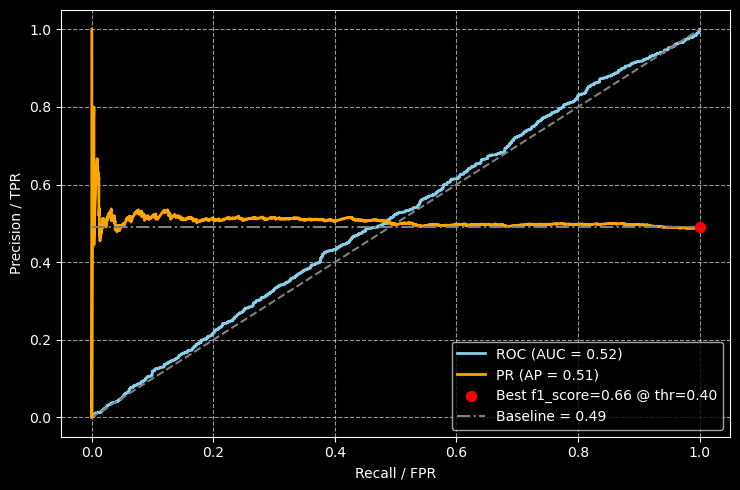

In [22]:
model_ma_fh_time = train_model(model=rf, X=ma_feat_time, events=ma_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_fh_time, plot=True)

2025-09-23 21:13:20 | INFO     | Samples are equally weighted.
2025-09-23 21:13:20 | INFO     | Training on 5,339 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1621
           1       0.29      1.00      0.45       670

    accuracy                           0.29      2291
   macro avg       0.15      0.50      0.23      2291
weighted avg       0.09      0.29      0.13      2291


Confusion Matrix:
[[   0 1621]
 [   0  670]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.48      0.58      1621
           1       0.31      0.56      0.40       670

    accuracy          

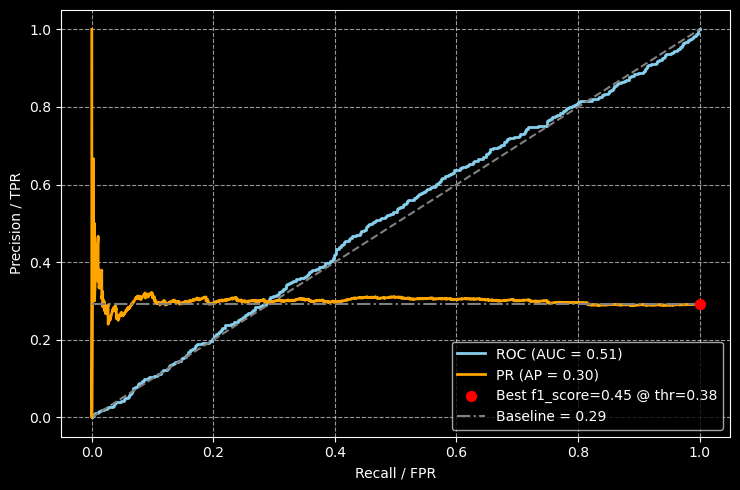

In [23]:
model_ma_tb_time = train_model(model=rf, X=ma_feat_time, events=ma_events_tb_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_tb_time, plot=True)

In [109]:
model_ma_trend_time = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time)

model_ma_trend_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w)

2025-09-24 02:08:33 | INFO     | Samples are equally weighted.
2025-09-24 02:08:33 | INFO     | Training on 5,317 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.53      0.05      0.09      1161
           1       0.49      0.96      0.65      1125

    accuracy                           0.49      2286
   macro avg       0.51      0.50      0.37      2286
weighted avg       0.51      0.49      0.36      2286


Confusion Matrix:
[[  55 1106]
 [  49 1076]]
2025-09-24 02:08:51 | INFO     | Samples weighted by t_value.
2025-09-24 02:08:51 | INFO     | Training on 5,317 samples...

------------------------------------------------------------
TREND-SCANNING (σ = 0.0) T-VALUE WEIGHTED EVALUATION REPORT
-----------------

In [110]:
model_ma_trend_time1 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time1)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold1}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time1)

model_ma_trend_time_w1 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time1, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold1}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w1)

2025-09-24 02:09:13 | INFO     | Samples are equally weighted.
2025-09-24 02:09:13 | INFO     | Training on 5,317 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.05) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.49      0.07      0.13      1120
           0       0.12      1.00      0.21        76
           1       0.50      0.67      0.57      1090

    accuracy                           0.39      2286
   macro avg       0.37      0.58      0.30      2286
weighted avg       0.48      0.39      0.34      2286


Confusion Matrix:
[[ 83 303 734]
 [  0  76   0]
 [ 88 274 728]]
2025-09-24 02:09:32 | INFO     | Samples weighted by t_value.
2025-09-24 02:09:33 | INFO     | Training on 5,013 samples...

------------------------------------------------------------
TRE

In [111]:
model_ma_trend_time2 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time2)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold2}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time2)

model_ma_trend_time_w2 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time2, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold2}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w2)

2025-09-24 02:09:52 | INFO     | Samples are equally weighted.
2025-09-24 02:09:52 | INFO     | Training on 5,317 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.47      0.06      0.11      1051
           0       0.26      0.97      0.41       202
           1       0.50      0.67      0.57      1033

    accuracy                           0.42      2286
   macro avg       0.41      0.57      0.37      2286
weighted avg       0.46      0.42      0.35      2286


Confusion Matrix:
[[ 67 287 697]
 [  0 195   7]
 [ 75 261 697]]
2025-09-24 02:10:08 | INFO     | Samples weighted by t_value.
2025-09-24 02:10:08 | INFO     | Training on 4,739 samples...

------------------------------------------------------------
TREN

In [112]:
model_ma_trend_time3 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time3)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold3}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time3)

model_ma_trend_time_w3 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time3, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold3}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w3)

2025-09-24 02:10:25 | INFO     | Samples are equally weighted.
2025-09-24 02:10:25 | INFO     | Training on 5,317 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.2) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.55      0.15      0.24       889
           0       0.50      0.93      0.65       527
           1       0.48      0.59      0.53       870

    accuracy                           0.50      2286
   macro avg       0.51      0.56      0.47      2286
weighted avg       0.51      0.50      0.44      2286


Confusion Matrix:
[[133 238 518]
 [  0 488  39]
 [109 244 517]]
2025-09-24 02:10:43 | INFO     | Samples weighted by t_value.
2025-09-24 02:10:43 | INFO     | Training on 4,209 samples...

------------------------------------------------------------
TREN

In [113]:
model_ma_trend_time4 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time4)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold4}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time4)

model_ma_trend_time_w4 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time4, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold4}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w4)

2025-09-24 02:10:55 | INFO     | Samples are equally weighted.
2025-09-24 02:10:55 | INFO     | Training on 5,317 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.3) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.56      0.19      0.28       718
           0       0.66      0.89      0.75       861
           1       0.45      0.56      0.50       707

    accuracy                           0.57      2286
   macro avg       0.55      0.55      0.51      2286
weighted avg       0.56      0.57      0.53      2286


Confusion Matrix:
[[135 195 388]
 [  2 764  95]
 [106 204 397]]
2025-09-24 02:11:11 | INFO     | Samples weighted by t_value.
2025-09-24 02:11:11 | INFO     | Training on 3,653 samples...

------------------------------------------------------------
TREN

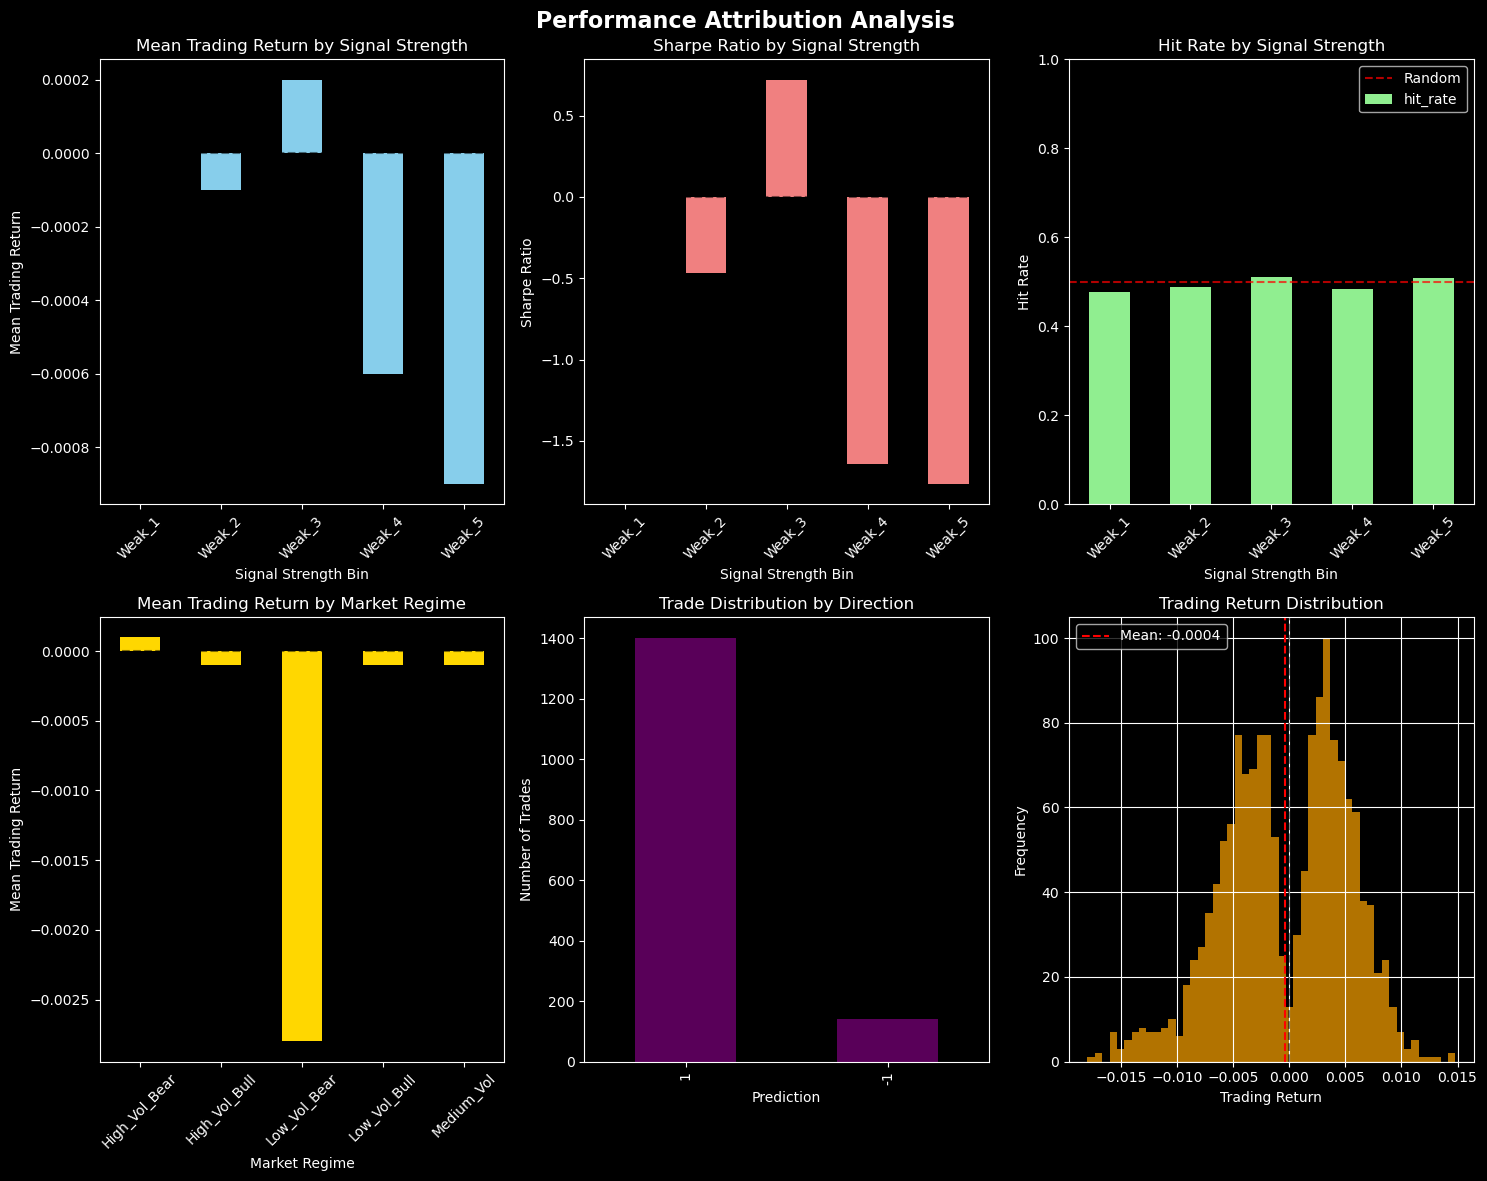

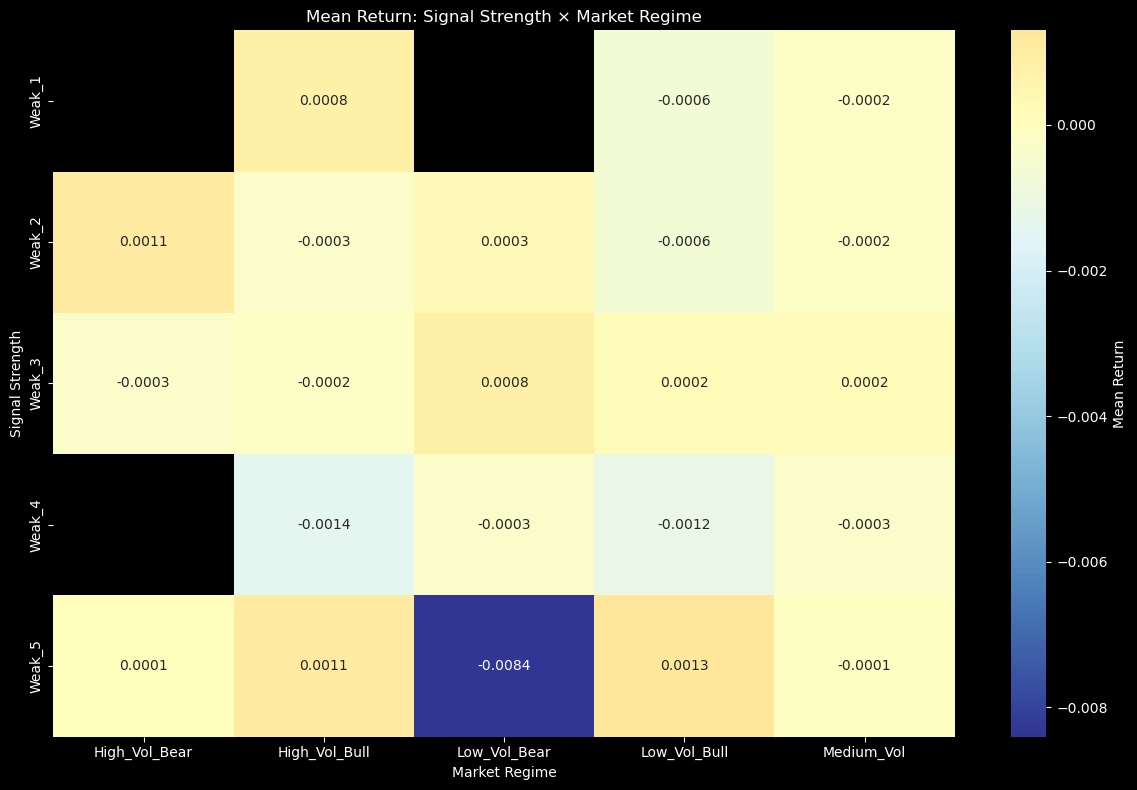

Signal Strength Analysis:
                     trading_return_count  trading_return_mean  \
signal_strength_bin                                              
Weak_1                                187              -0.0000   
Weak_2                                338              -0.0001   
Weak_3                                319               0.0002   
Weak_4                                341              -0.0006   
Weak_5                                358              -0.0009   

                     trading_return_std  trading_return_sum  abs_return_mean  \
signal_strength_bin                                                            
Weak_1                           0.0029             -0.0085           0.0023   
Weak_2                           0.0034             -0.0465           0.0030   
Weak_3                           0.0044              0.0533           0.0040   
Weak_4                           0.0058             -0.2171           0.0053   
Weak_5                         

In [136]:
from performance_attribution import performance_attribution_analysis

# predictions = model_ma_trend_time.fit.predict(ma_feat_time.loc[:sample_end])  # Optional
# predictions = pd.Series(predictions, index=ma_feat_time.loc[:sample_end].index)
model = model_ma_trend_time2
events = model.events
predictions = model.pred  # Optional
returns = ma_df.close.pct_change().reindex(events.index)  # Daily returns aligned with features

results = performance_attribution_analysis(
    labels_df=events,  # DataFrame with at least 'bin' and 'ret' columns
    returns=returns,
    predictions=predictions,  # Optional - if None, uses labels_df['bin']
    signal_strength_bins=5,   # or [0, 1, 2, 3, 5, 10] for custom bins
    regime_lookback=252,      # 1 year for market regime classification
    plot_results=True
)

# Access results
print("Signal Strength Analysis:")
pprint(results['signal_strength_analysis'], sort_dicts=False)

print("\nMarket Regime Analysis:")
pprint(results['market_regime_analysis'], sort_dicts=False)

print("\nSummary Stats:")
for key, value in results['summary_stats'].items():
    print(f"{key}: {value:.4f}")


###### Return-Weighted

In [ ]:
model_ma_fh_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_fh_time, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_fh_time_w, plot=True)

In [ ]:
model_ma_tb_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_tb_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_tb_time_w, plot=True)

2025-09-22 20:08:48 | INFO     | Samples weighted by t_value.
2025-09-22 20:08:48 | INFO     | Training on 4,181 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.3) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1226
           1       0.32      1.00      0.48       565

    accuracy                           0.32      1791
   macro avg       0.16      0.50      0.24      1791
weighted avg       0.10      0.32      0.15      1791


Confusion Matrix:
[[   0 1226]
 [   0  565]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1226
           1       0.32      1.00      0.48       565

    accuracy 

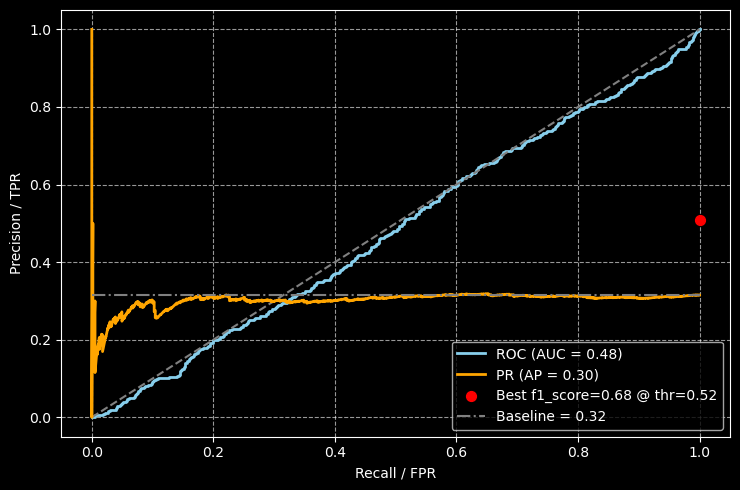

In [ ]:
model_ma_trend_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_tb_time, weighting="t_value")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_trend_time_w, plot=True)

###### Time-Decay Weighted

In [ ]:
model_ma_fh_time_tw = train_model(model=rf, X=ma_feat_time, events=ma_events_fh_time, weighting="time", time_decay=time_decay)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_fh_time_tw, plot=True)

In [ ]:
model_ma_tb_time_tw = train_model(model=rf, X=ma_feat_time, events=ma_events_tb_time, weighting="time", time_decay=time_decay)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_tb_time_tw, plot=True)

In [ ]:
model_ma_trend_time_tw = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_tb_time, weighting="time", time_decay=time_decay)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_trend_time_tw, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "time_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_time_horizon})", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    ]
ma_models = [model_ma_fh_time, model_ma_tb_time] 
ma_trends = [model_ma_trend_time, model_ma_trend_time1, 
             model_ma_trend_time2, model_ma_trend_time3, model_ma_trend_time4]
ma_vol_thresholds = [volatility_threshold, volatility_threshold1, volatility_threshold2,
                     volatility_threshold3, volatility_threshold4]
# ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
# ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

# ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
# ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labeling_classification_report_tables(
    model_data=ma_trends, 
    methods=ma_vol_thresholds, 
    title=f"{ma_strategy.get_strategy_name()}"
    )

In [102]:
ma_trends_w = [model_ma_trend_time_w, model_ma_trend_time_w1, model_ma_trend_time_w2, 
               model_ma_trend_time_w3, model_ma_trend_time_w4]
meta_labeling_classification_report_tables(
    model_data=ma_trends_w, 
    methods=ma_vol_thresholds, 
    title=f"{ma_strategy.get_strategy_name()}_weighted"
    )

Reloading 'afml.backtester.reporting'.
2025-09-24 01:35:50 | INFO     | Saved to ..\reports\MACrossover_50_100_weighted_classification_comparison.html

                      0.0      0.05       0.1      0.2      0.3
class                                                          
-1    precision     0.481     0.487     0.491    0.466    0.467
      recall        0.098     0.501     0.309    0.113    0.081
      f1-score      0.163     0.494     0.379    0.181    0.138
      support    1161.000  1083.000  1014.000  914.000  779.000
1     precision     0.489     0.480     0.499    0.488    0.502
      recall        0.891     0.466     0.683    0.868    0.909
      f1-score      0.631     0.473     0.577    0.625    0.647
      support    1125.000  1071.000  1022.000  891.000  794.000


##### Out-of-Sample

In [ ]:
# Create events set for model
df = ma_time_bars[sample_end:]
close = df.close.copy()
target = get_daily_vol(ma_time_bars.close, vol_lookback).reindex(df.index) * ma_vol_multiplier

side, t_events = get_entries(ma_strategy, df, on_crossover=0)
vertical_barrier_times = add_vertical_barrier(t_events, close, num_bars=ma_time_horizon)

# Create feature set for model
X_test = ma_feat_time.reindex(t_events).dropna().copy()
value_counts_data(X_test.side, verbose=True)
X_test.info()

ma_events_fh_time_oos = get_events(
    close, t_events, 
    pt_sl=[0, 0],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=ma_side,
    )

ma_events_tb_time_oos = get_events(
    close, t_events, 
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=ma_side,
    )

ma_events_trend_time_oos = get_events(
    close, t_events, 
    pt_sl=[0, ma_sl_barrier],
    target=target, 
    vertical_barrier_times=vertical_barrier_times,
    side_prediction=ma_side,
    )
ma_events_trend_time_oos["side"] = model_ma_trend_time_w1.predict(X_test.drop(columns=["side"]))

labeling_methods = [
    "fixed_horizon", 
    "triple_barrier", 
    "trend_scanning", 
    ]
models = [model_ma_fh_time, model_ma_tb_time, model_ma_trend_time_w1]
events_oos = {"fixed_horizon": ma_events_fh_time_oos, 
              "triple_barrier": ma_events_tb_time_oos,
              "trend_scanning": ma_events_trend_time_oos,
              }

2025-09-22 20:30:18 | INFO     | MACrossover_20_50 | 36,913 (100.00%) trade events.

       count  proportion
side                    
-1    18,482    0.500691
 1    18,431    0.499309

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36913 entries, 2022-01-03 01:30:00 to 2024-12-31 00:00:00
Data columns (total 86 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           36913 non-null  float32
 1   ma_20                           36913 non-null  float32
 2   ma_50                           36913 non-null  float32
 3   ma_100                          36913 non-null  float32
 4   ma_200                          36913 non-null  float32
 5   ma_10_20_cross                  36913 non-null  float64
 6   ma_20_50_cross                  36913 non-null  float64
 7   ma_50_200_cross                 36913 non-null  float64
 8   ma_spread_10_20                 36913 non-null  float32

In [124]:
bet_sizing_methods = [None, 'probability', 'budget', 'reserve', 'dynamic']
bet_sizing = bet_sizing_methods[0]

if bet_sizing == "probability":
    bet_sizing_args = dict(step_size=0.0, average_active=False)
else:
    bet_sizing_args = dict()

ma_model_results_time = {}
time_metrics_oos = {"primary_model": {}, "meta_model": {}}
ma_metrics_time = pd.DataFrame()

In [127]:
n = len(labeling_methods)
i, j = 0, n
for model_name, model in zip(labeling_methods[i : j], models[i : j]):
    prob = model.fit.predict_proba(X_test)[:, 1]
    prob = pd.Series(prob, index=X_test.index)
    name = f"{ma_strategy.get_strategy_name()} ({model_name.replace('_', ' ').title()})"
    results = run_meta_labeling_analysis(
        events=events_oos[model_name],
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=name,
        bet_sizing=bet_sizing,
        **bet_sizing_args
        )
    ma_model_results_time[model_name] = results
    ma_metrics_time[model_name] = results["meta_metrics"]

ma_metrics_time

2025-09-22 20:30:31 | INFO     | Bet Sizing Method: None | Confidence Threshold: 0.5

Meta-Labeling Performance Analysis: MACrossover_20_50 (Fixed Horizon)

Signal Filtering Summary:
  Total Primary Signals: 36,713
  Filtered Signals: 23,399
  Filter Rate: 36.27%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   -99.90%         -100.00%        -0.1%          
Annualized Return              -90.08%         -96.92%         -7.6%          
Sharpe Ratio                   -1.5409         -4.0034         -159.8%        
Sortino Ratio                  -2.3694         -6.0821         -156.7%        
Calmar Ratio                   -0.9008         -0.9692         -7.6%          

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   100.00%         100.00%         +0.0%          
Avg Drawdown                   54.77%          42.75%          +21.9%     

,fixed_horizon,triple_barrier,trend_scanning
total_return,-0.999971,6.150512,-0.999229
annualized_return,-0.969233,0.926256,-0.90824
volatility,1.194873,0.736788,0.841619
downside_volatility,0.786498,0.206578,0.207511
sharpe_ratio,-4.003414,1.772448,-4.064766
sortino_ratio,-6.082119,6.321665,-16.485822
var_95,-0.017883,-0.007307,-0.007337
cvar_95,-0.024469,-0.008591,-0.008611
skewness,0.000319,0.822517,1.784479
kurtosis,1.067503,-0.333744,3.329696


##### Tick-Bars

In [ ]:
model_ma_fh_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_fh_tick, plot=True)

In [ ]:
model_ma_tbl_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_tb_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_tbl_tick, plot=True)

In [ ]:
model_ma_trend_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_trend_tick, plot=True)

In [ ]:
model_ma_trend_mr_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_trend_mr_tick, plot=True)

In [ ]:
dirpath = Path("reports", "tick_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_tick_horizon} minutes)", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_tick_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_tick, model_ma_tbl_tick, model_ma_trend_tick, model_ma_trend_mr_tick]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labeling_classification_report_tables(model_data=ma_models, title=bb_titles, output_filename=dirpath / "ma_fixed_tick")